In [1]:
import re
import pandas as pd
import nltk
import tensorflow as tf
import tensorflow_datasets as tfds
from nltk.tokenize import word_tokenize
from nltk.tokenize import regexp_tokenize

In [2]:
import pandas as pd

In [3]:
train_file_path = '../aiffel/train.csv'
test_file_path = '../aiffel/test.csv'
normal_file_path = '../aiffel/normal_data.csv'

In [16]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
normal = pd.read_csv(normal_file_path)

In [17]:
print('train_df 전체 샘플 수 :', len(train_df))
print('test_df 전체 샘플 수 :', len(test_df))
print('normal 전체 샘플 수 :', len(normal))

train_df 전체 샘플 수 : 3950
test_df 전체 샘플 수 : 500
normal 전체 샘플 수 : 33028


In [18]:
train_df.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [19]:
normal = normal.sample(frac=1).reset_index(drop=True)

In [20]:
normal.head()

,0
0,근데 초등학생 애들 잘 먹나요?\n네 먹을 수 있습니
1,만두도 따로 구매 가능한가요?\n네 가능합니다\n김치만두랑 떡국 둘 다 가장 작은 ...
2,"대실 되나요?\n네, 대실 가능하세"
3,피자를 3명이 먹을 건데 사이즈는 어떤 거 하면 좋겠어요?\n라지 하나 하시면 될 ...
4,음 제가 옷을 잘 못 고르는데 좀 도와주시겠어요?\n네 누가 입을 건가요\n네 딸이...


In [21]:
test_df.head()

,idx,text
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [22]:
label_map = {'협박 대화': 0, '갈취 대화': 1, '직장 내 괴롭힘 대화': 2, '기타 괴롭힘 대화': 3, '일반 대화': 4}

In [23]:
train_df['encoded_label'] = train_df['class'].map(label_map)

print(train_df['encoded_label'].unique())
train_df.tail()

[0 3 1 2]


,idx,class,conversation,encoded_label
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...,3
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...,1
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...,2
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...,1
3949,3949,직장 내 괴롭힘 대화,희정씨\n네?\n주말에 시간이 넘쳐나나봐\n갑자기 왜그러세요?\n손이 빤짝빤짝 네일...,2


In [24]:
normal = normal.rename(columns={'0': 'conversation'})
normal['encoded_label'] = 4
normal.head()

,conversation,encoded_label
0,근데 초등학생 애들 잘 먹나요?\n네 먹을 수 있습니,4
1,만두도 따로 구매 가능한가요?\n네 가능합니다\n김치만두랑 떡국 둘 다 가장 작은 ...,4
2,"대실 되나요?\n네, 대실 가능하세",4
3,피자를 3명이 먹을 건데 사이즈는 어떤 거 하면 좋겠어요?\n라지 하나 하시면 될 ...,4
4,음 제가 옷을 잘 못 고르는데 좀 도와주시겠어요?\n네 누가 입을 건가요\n네 딸이...,4


In [25]:
normal[:900].tail()

,conversation,encoded_label
895,요런 조끼는 얼마씩 해요?\n이 옷이 삼만 이천 원이에,4
896,선물하려면 10만원 정도는 음 싼 거 있어요?\n싼 제품 중에는 5만원 짜리도 있어,4
897,이 옷은 얼마라예?\n그 옷은 33만 원이에,4
898,몇 평 정도 보시나요?\n60평짜리,4
899,비용은 얼마인가요?\n7만 원입니,4


In [26]:
train_df = pd.concat([train_df, normal[:900]], axis=0, ignore_index=True)
train_df.tail()

,idx,class,conversation,encoded_label
4845,NaN,NaN,요런 조끼는 얼마씩 해요?\n이 옷이 삼만 이천 원이에,4
4846,NaN,NaN,선물하려면 10만원 정도는 음 싼 거 있어요?\n싼 제품 중에는 5만원 짜리도 있어,4
4847,NaN,NaN,이 옷은 얼마라예?\n그 옷은 33만 원이에,4
4848,NaN,NaN,몇 평 정도 보시나요?\n60평짜리,4
4849,NaN,NaN,비용은 얼마인가요?\n7만 원입니,4


In [27]:
# 필요없는 컬럼 삭제 후 데이터 셔플
train_df = train_df.drop(columns=['idx', 'class'])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df.head()

,conversation,encoded_label
0,저기요 저 짜장면 시켰는데 왜 단무지가 안오는 거죠?\n 저희가 단무지 안보내드렸나...,3
1,못생긴 새끼\n그만해\n못생긴 새끼\n왜 마주칠 때 마다 그래\n못생겼으니까\n그만...,3
2,가진게 없다하니 건강한게 다행이구만 신장이 좋으려나\n금방 해결 할 수 있습니다\n...,0
3,카드 주문은 여기서 안 되나요?\n카드 결제는 제가 직접 하나요?\n카드는 여기에 ...,4
4,저기요 주차 좀 똑바로 해주세요\n 뭐 이새끼야? 니 층 살지?\n 그걸 왜 물어보...,0


In [29]:
from sklearn.model_selection import train_test_split

In [31]:
X = train_df['conversation'].to_list()
Y = train_df['encoded_label'].to_list()

In [32]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 49,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 49,
                                                stratify = y_val_test)

In [34]:
from collections import Counter

In [35]:
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4365
y_train 개수 : 4365
x_val 개수 : 242
y_val 개수 : 242
x_test 개수 : 243
y_test 개수 : 243
훈련 데이터 레이블 비율 확인 : Counter({3: 985, 1: 883, 2: 881, 4: 810, 0: 806})
검증 데이터 레이블 비율 확인 : Counter({3: 54, 2: 49, 1: 49, 0: 45, 4: 45})
테스트 데이터 레이블 비율 확인 : Counter({3: 55, 1: 49, 2: 49, 0: 45, 4: 45})


# "klue/bert-base"

In [36]:
from transformers import BertTokenizer, TFBertForSequenceClassification

HUGGINGFACE_MODEL_PATH = "klue/bert-base"
# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH)

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [37]:
# Tokenizing
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

for key in train_encodings:
  print(f"{key} : {train_encodings[key][0]}")

input_ids : [2, 732, 2116, 743, 5232, 3269, 5882, 2299, 850, 1571, 3637, 2318, 1, 1127, 2154, 1233, 2776, 2318, 850, 4707, 2279, 7245, 1460, 1127, 6233, 1806, 2225, 2155, 4229, 9041, 1097, 2529, 15547, 2203, 21619, 5232, 2456, 568, 3663, 2088, 28653, 2073, 6518, 5232, 3269, 9958, 3775, 1097, 850, 4676, 2088, 35, 27378, 850, 13932, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [38]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))
train_dataset

<TensorSliceDataset shapes: ({input_ids: (458,), token_type_ids: (458,), attention_mask: (458,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

In [40]:
num_labels = 5
model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])
model.summary()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 110,621,189
Trainable params: 110,621,189
Non-trainable params: 0
_________________________________________________________________


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(
    train_dataset.shuffle(1000).batch(4), epochs=1, batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks = [callback_earlystop]
)

1092/1092 [==============================] - 496s 454ms/step - loss: 0.2162 - accuracy: 0.9294 - val_loss: 0.3535 - val_accuracy: 0.9050


In [56]:
model_path = "./model/fine-tuned-klue-bert-base"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-bert-base/tokenizer_config.json',
 './model/fine-tuned-klue-bert-base/special_tokens_map.json',
 './model/fine-tuned-klue-bert-base/vocab.txt',
 './model/fine-tuned-klue-bert-base/added_tokens.json')

In [57]:
from transformers import TextClassificationPipeline

# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-bert-base"
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-bert-base were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-bert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 243/243 [01:36<00:00,  2.52it/s]


In [46]:
# epoch 1
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88        45
           1       0.80      0.84      0.82        49
           2       0.92      0.98      0.95        49
           3       0.98      0.75      0.85        55
           4       1.00      1.00      1.00        45

    accuracy                           0.90       243
   macro avg       0.90      0.90      0.90       243
weighted avg       0.90      0.90      0.90       243



In [59]:
# epoch 2
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87        45
           1       0.89      0.82      0.85        49
           2       0.94      0.94      0.94        49
           3       0.96      0.80      0.87        55
           4       1.00      1.00      1.00        45

    accuracy                           0.91       243
   macro avg       0.91      0.91      0.91       243
weighted avg       0.91      0.91      0.91       243



In [47]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [48]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
2,이야 내동생 여자친구한테 편지쓰네?\n 아 형 돌려줘.\n 어디보자. 사랑하는 여친...,3,1
4,감독님 저 더 이상 시나리오 못짜겠습니다. 대신 그동안 작업해놨는 것을 이어서 다른...,3,2
7,오늘 그 블라우스 너무 잘 어울리던데요\n 아. 네 감사합니다.\n 근데 안에 속 ...,3,1
14,여기 음식이 왜 이리 맛이 없어요?\n손님 죄송합니다.저희가 주방에 말씀드릴게요\n...,3,1
16,다 손 들고 가만히 있어\n이봐요 지금 뭐하시는 겁니까\n나 지금 제 정신 아니니까...,1,0
20,돈 모으기만 해서 뭐하냐?\n신경꺼.\n쓰지는 않고 거지냐?\n쓰는데 아끼는거야.\...,3,1
27,어이 남 비서!\n네 회장님! 무슨 일이십니까?\n요새 자네 태도가 너무 마음에 안...,2,0
30,어머니 땅문서 어딨어요??\n그땅은 안된다\n안되는게 어딨어요 땅문서 어딨냐니까요\...,1,0
32,당신 부인을 데리고있다\n원하시는게\n내가 지정한사물함에 돌을넣어놓지않으면 장기밀매...,1,0
38,돈갚아\n돈없는데 어떻게 갚아\n남의돈을 떼먹고 넌 여기서 희희낙낙이야\n니돈갚으면...,0,1


In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51649 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51109 missing from current font.
  font.set_

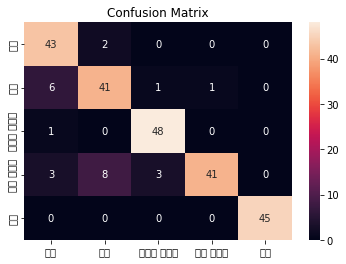

In [53]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

---

In [60]:
X_test = test_df['text'].to_list()

In [61]:
X_test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [63]:
X_test_dataset = tf.data.Dataset.from_tensor_slices(dict(X_test_encodings))

In [64]:
predictions = model.predict(X_test_dataset)

In [65]:
# 예측된 logits 추출
logits = predictions.logits
logits

array([[ 1.0016139 , -1.0837449 ,  1.7311193 ,  2.1848395 , -4.5127344 ],
       [ 0.34832263, -1.2461748 ,  2.5111783 ,  0.9569961 , -2.2078178 ],
       [-0.04833257, -1.4500437 ,  1.190486  ,  1.3935494 , -1.5086994 ],
       ...,
       [ 0.8655734 , -1.2098961 ,  2.0943613 ,  1.22375   , -3.3337865 ],
       [ 0.8655734 , -1.2098961 ,  2.0943613 ,  1.22375   , -3.3337865 ],
       [ 0.8655734 , -1.2098961 ,  2.0943613 ,  1.22375   , -3.3337865 ]],
      dtype=float32)

In [67]:
import numpy as np

In [73]:
# logits -> 예측된 클래스 (가장 높은 확률을 가진 클래스를 선택)
pred_labels = np.argmax(logits, axis=-1)

In [74]:
# 모든 행과 열 출력하도록 설정
pd.set_option('display.max_rows', None)  # 모든 행 출력
pd.set_option('display.max_columns', None)  # 모든 열 출력
pd.set_option('display.width', None)  # 행 길이에 제한 없이 출력
pd.set_option('display.max_colwidth', None)  # 열 너비 제한 없애기

# pred_labels 출력
print(pred_labels)

[3 2 3 ... 2 2 2]


In [71]:
with open('pred_labels_output.txt', 'w') as f:
    f.write(str(pred_labels))